### 딥러닝을 활용한 Naver 영화 리뷰 감성 분석
우선 Naver 데이터 셋을 받고 그 후 리뷰 분석을 시작해 봅시다. 

[네이버 영화 리뷰 데이터셋 ](https://github.com/e9t/nsmc "네이버 영화리뷰 데이터셋") 

- 데이터 준비 및 맞게 불러졌는지 확인

In [1]:
# 시작하기에 앞서 한국어 정보 처리를 위한 패키지를 다운 받읍시다.
# konlpy 패키지 설치
# 한국어 정보처리를 위한 파이썬 패키지 [우분투]
# sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x

# 2.MeCab 설치하기 (선택사항)
# sudo apt-get install curl
# bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

# [윈도우]
# pip install konlpy

SyntaxError: invalid syntax (<ipython-input-1-46fccf796064>, line 1)

In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf
tf.random.set_seed(14) # 실험환경 셋팅 seed 고정
# 데이터를 읽어봅시다. 

In [6]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- IMDB 데이터셋은 가공한 텍스트를 딕셔너리로 제공 했지만, <br>nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다. 

따라서 이것을 가공하여 imdb.data_lodaer()과 동일하게 동작하는 data_loder를 만들어야 한다. 

### 가공 할때 생각해야 하는 요소들

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴


##### Numpy 함수 
- concatenate :<br>
  Numpy 배열들을 하나로 합치는 함수

In [58]:
import numpy as np

a = np.array([[1, 2], [3, 4]])
b = np.array([[7, 8], [9, 10], [11, 12]])

print(np.concatenate((a, b), axis=0))
print(np.concatenate((a, b.T), axis=1))
print(np.concatenate((a, b), axis=None))

[[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]
 [11 12]]
[[ 1  2  7  9 11]
 [ 3  4  8 10 12]]
[ 1  2  3  4  7  8  9 10 11 12]


In [59]:
type(train_data) #  train_data 형식 확인 pandas로 가져와서 DataFrame이다.

pandas.core.frame.DataFrame

In [7]:
# 가공하고 load_data 해야한다.
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # concatenate : Numpy 배열들을 하나로 합치는 함수

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [8]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10


In [10]:
# word_to_index -> index_to_word
index_to_word = {index:word for word, index in word_to_index.items()}

In [11]:
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 데이터 분석 , 패딩

In [53]:
# train data 확인
x_train

[[32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391],
 [24, 205, 2],
 [8410, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479],
 [2,
  8894,
  1108,
  52,
  2832,
  60,
  5,
  14,
  2758,
  41,
  1188,
  35,
  351,
  42,
  22,
  40,
  60,
  2,
  2,
  427,
  3102,
  1766,
  6],
 [675,
  2,
  2,
  131,
  420,
  185,
  1547,
  712,
  65,
  1694,
  715,
  53,
  375,
  192,
  271,
  5,
  4,
  69,
  4,
  11,
  2179,
  122,
  750,
  4],
 [253, 381, 9, 384, 2012, 55, 15, 817, 6, 4],
 [232,
  1450,
  144,
  6,
  425,
  756,
  2,
  2,
  52,
  1532,
  290,
  99,
  250,
  4,
  4,
  28,
  855,
  29,
  353,
  652,
  540,
  509,
  583,
  6,
  3318,
  4,
  8895,
  22,
  1460,
  1460,
  4,
  4,
  71,
  304,
  17,
  6,
  52,
  104,
  8,
  77,
  22,
  2,
  43],
 [128, 17, 23, 94, 16, 290, 27, 48, 5],
 [63,
  656,
  58,
  240,
  760,
  18,
  574,
  89,
  2,
  4,
  4,
  1482,
  637,
  736,
  81,
  22,
  24,
  2,
  16,
  20,
  18],
 [2, 4,

In [12]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[1])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  1


In [48]:
print(get_decoded_sentence(x_train[1], index_to_word))
print('라벨: ', y_train[1])

. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1


- 디코드 하면서 데이터 확인

#### 패딩할 데이터 길이 확인

In [13]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]  # 문장의 길이로 이루어진 리스트 생성
num_tokens = np.array(num_tokens)   # ndarray로 변환
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# maxlen지정 : 최대 길이를 (평균 + 2.5*표준편차)로 지정  
max_tokens = np.mean(num_tokens) + 2.8 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021
pad_sequences maxlen :  51
전체 문장의 0.9631000465856793%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences 패딩 진행
- 영어의 경우 중요한 문장이 앞쪽에 있어서 pre 부분의 중요한 점이 많았지만, <br> 한국어 특성상 뒷쪽에 중요한 내용이 있어서 뒷 post를 먼저 진행한다.

In [14]:
# padding을 post(뒷쪽)으로 결정
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

In [15]:
print(x_train.shape)

(146182, 51)


## 모델 구성 및 설계

- 1. RNN 모델 사용
  - LSTM, GRU   
  
- 1.1 LSTM 모델 사용  
- LSTM 사용 후 GRU 모델의 그래프가 완만해서 해당 모델을 사용했습니다.

In [156]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 32  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 
                        # LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
                        # 1차시 8, 2차시 16
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 328,593
Trainable params: 328,593
Non-trainable params: 0
_________________________________________________________________


- 총 x_train data의 약10% 분리하기

- 131564 : train data
- 14618 : val data

=> 
```
1537/1537 - 2s - loss: 0.4190 - accuracy: 0.8388
[0.4189649522304535, 0.8388022184371948]
```

- 총 x_train data의 약20% 분리하기

- 116946 : train data
- 29236 : val data

=> 
```
조금 더 나은 성능
1537/1537 - 2s - loss: 0.4386 - accuracy: 0.8433
[0.438597172498703, 0.8432573080062866]
```
---

```
model_vector_dim = 32
LSTM(32) 
1537/1537 - 2s - loss: 0.4610 - accuracy: 0.8398
[0.46100175380706787, 0.8397989869117737]
```

In [157]:
# validation set 분리
separation_train = int(x_train.shape[0]*0.2)
x_val = x_train[:separation_train]   
y_val = y_train[:separation_train]

# validation set을 제외한 나머지
partial_x_train = x_train[separation_train:]  
partial_y_train = y_train[separation_train:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(116946, 54)
(116946,)
(29236, 54)
(29236,)


- 1.1 RNN모델 학습 

In [158]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # 0, 1 이진 문제므로 binary_crossentropy 사용
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# batch_size -> 256

Epoch 1/15
229/229 [==============================] - 2s 9ms/step - loss: 0.5404 - accuracy: 0.6891 - val_loss: 0.3625 - val_accuracy: 0.8444
Epoch 2/15
229/229 [==============================] - 2s 8ms/step - loss: 0.3438 - accuracy: 0.8537 - val_loss: 0.3462 - val_accuracy: 0.8497
Epoch 3/15
229/229 [==============================] - 2s 8ms/step - loss: 0.3202 - accuracy: 0.8638 - val_loss: 0.3443 - val_accuracy: 0.8509
Epoch 4/15
229/229 [==============================] - 2s 8ms/step - loss: 0.3041 - accuracy: 0.8711 - val_loss: 0.3525 - val_accuracy: 0.8434
Epoch 5/15
229/229 [==============================] - 2s 8ms/step - loss: 0.2927 - accuracy: 0.8753 - val_loss: 0.3601 - val_accuracy: 0.8498
Epoch 6/15
229/229 [==============================] - 2s 8ms/step - loss: 0.2804 - accuracy: 0.8789 - val_loss: 0.3711 - val_accuracy: 0.8465
Epoch 7/15
229/229 [==============================] - 2s 8ms/step - loss: 0.2669 - accuracy: 0.8840 - val_loss: 0.3556 - val_accuracy: 0.8501
Epoch 

In [159]:
# 모델 평가
model_results = model.evaluate(x_test,  y_test, verbose=2)
print(model_results)

1537/1537 - 2s - loss: 0.4475 - accuracy: 0.8368
[0.44747117161750793, 0.8367882370948792]


In [160]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- 그래프로 그려 시각화

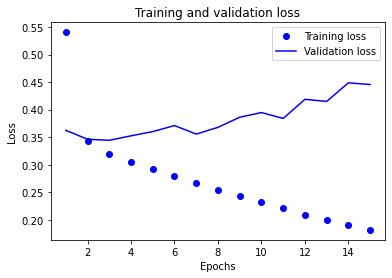

In [161]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점 추정


- validation loss의 그래프가 train loss와의 이격이 너무 빠르게 발생 -> 문제

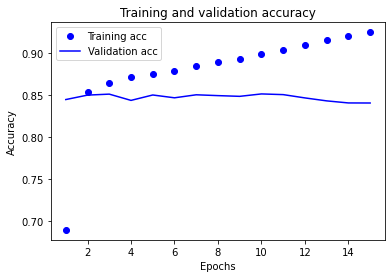

In [162]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 마찬가지로 빠른 이격 발생

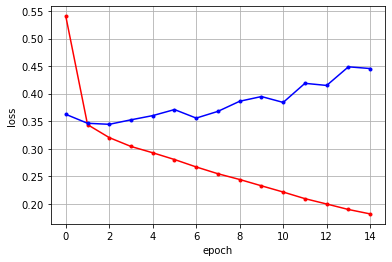

In [163]:
y_loss = history.history['loss']
y_val_loss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### LSTM 모델 
- 총 x_train data의 약10% 분리하기

- 131564 : train data
- 14618 : val data

=> 
```
1537/1537 - 2s - loss: 0.4190 - accuracy: 0.8388
[0.4189649522304535, 0.8388022184371948]
```

- 총 x_train data의 약20% 분리하기

- 116946 : train data
- 29236 : val data

=> 
```
조금 더 나은 성능
1537/1537 - 2s - loss: 0.4386 - accuracy: 0.8433
[0.438597172498703, 0.8432573080062866]
```
---

```
model_vector_dim = 32
LSTM(32) 
1537/1537 - 2s - loss: 0.4610 - accuracy: 0.8398
[0.46100175380706787, 0.8397989869117737]
```

---

### 1.2 GRU 모델 사용  

In [164]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GRU(22))   # RNN 모델 중 GRU 레이어를 사용하였습니다. 
                        # 1차시 8, 2차시 16...
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 30)          300000    
_________________________________________________________________
gru_3 (GRU)                  (None, 22)                3564      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 184       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 303,757
Trainable params: 303,757
Non-trainable params: 0
_________________________________________________________________


In [22]:
# validation set 분리
separation_train = int(x_train.shape[0]*0.2)
x_val = x_train[:separation_train]   
y_val = y_train[:separation_train]

# validation set을 제외한 나머지 
partial_x_train = x_train[separation_train:]  
partial_y_train = y_train[separation_train:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(116946, 51)
(116946,)
(29236, 51)
(29236,)


- 1.2 GRU모델 학습 

In [166]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # 0, 1 이진 문제므로 binary_crossentropy 사용
              metrics=['accuracy'])
              
epochs=12  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# batch_size -> 256

Epoch 1/12
229/229 [==============================] - 2s 8ms/step - loss: 0.6472 - accuracy: 0.5736 - val_loss: 0.4213 - val_accuracy: 0.8153
Epoch 2/12
229/229 [==============================] - 2s 7ms/step - loss: 0.3651 - accuracy: 0.8424 - val_loss: 0.3466 - val_accuracy: 0.8504
Epoch 3/12
229/229 [==============================] - 2s 9ms/step - loss: 0.3242 - accuracy: 0.8644 - val_loss: 0.3443 - val_accuracy: 0.8507
Epoch 4/12
229/229 [==============================] - 2s 8ms/step - loss: 0.3095 - accuracy: 0.8711 - val_loss: 0.3442 - val_accuracy: 0.8500
Epoch 5/12
229/229 [==============================] - 2s 8ms/step - loss: 0.2981 - accuracy: 0.8768 - val_loss: 0.3442 - val_accuracy: 0.8528
Epoch 6/12
229/229 [==============================] - 2s 8ms/step - loss: 0.2878 - accuracy: 0.8817 - val_loss: 0.3425 - val_accuracy: 0.8559
Epoch 7/12
229/229 [==============================] - 2s 8ms/step - loss: 0.2773 - accuracy: 0.8868 - val_loss: 0.3368 - val_accuracy: 0.8561
Epoch 

In [167]:
# 모델 평가
model_results = model.evaluate(x_test,  y_test, verbose=2)
print(model_results)

1537/1537 - 2s - loss: 0.3730 - accuracy: 0.8503
[0.3729948401451111, 0.8502756357192993]


In [168]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- 그래프로 그려 시각화

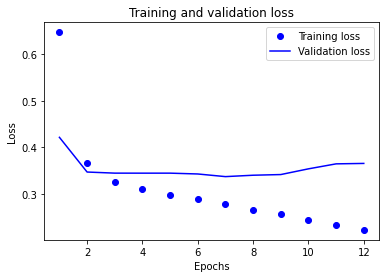

In [169]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- LSTM과 비교했을때 상대적으로 완만한 그래프를 그린다.


- LSTM 보다 GRU로 했을때 모델의 학습이 더 잘 이루어졌다.


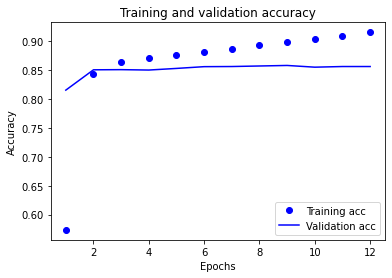

In [170]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

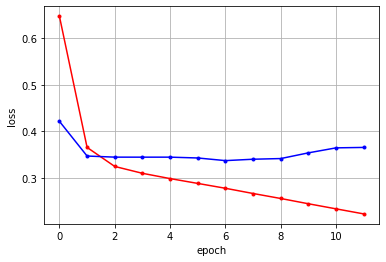

In [171]:
y_loss = history.history['loss']
y_val_loss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

- LSTM 보다 GRU 모델의 그래프가 완만하고 더 좋은 결과가 나왔다.

#### GRU 모델 사용
- x_train data의 약 20% 분리
- LSTM과 동일

``` 
post
(GRU)(16)
1537/1537 - 2s - loss: 0.3851 - accuracy: 0.8457
[0.3850516974925995, 0.8456781506538391]
# 그래프도 완만한 그래프를 그렸다.
```

```
post
GRU(32) 
1537/1537 - 2s - loss: 0.6588 - accuracy: 0.8339
[0.6587523221969604, 0.833919882774353]
```

```
pre
word_vector_dim : 30
GRU(22)
1537/1537 - 2s - loss: 0.3730 - accuracy: 0.8503
[0.3729948401451111, 0.8502756357192993]
```

### 1-D CNN
- CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습속도가 더 빠르게 되는 장점이 있다.   (학습 속도 : CNN > RNN )

In [219]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 25   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(4))
model.add(keras.layers.Conv1D(128, 7, activation='relu'))

model.add(keras.layers.GlobalMaxPooling1D()) 

model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 25)          250000    
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 32)          5632      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 128)         28800     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_33 (Dense)             (None, 1)               

In [220]:
# validation set 분리
separation_train = int(x_train.shape[0]*0.2)
x_val = x_train[:separation_train]   
y_val = y_train[:separation_train]

# validation set을 제외한 나머지
partial_x_train = x_train[separation_train:]  
partial_y_train = y_train[separation_train:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(116946, 54)
(116946,)
(29236, 54)
(29236,)


In [221]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # 0, 1 이진 문제므로 binary_crossentropy 사용
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# batch_size -> 256

Epoch 1/10
229/229 [==============================] - 13s 56ms/step - loss: 0.4612 - accuracy: 0.7664 - val_loss: 0.3401 - val_accuracy: 0.8519
Epoch 2/10
229/229 [==============================] - 1s 6ms/step - loss: 0.3141 - accuracy: 0.8660 - val_loss: 0.3288 - val_accuracy: 0.8587
Epoch 3/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2767 - accuracy: 0.8857 - val_loss: 0.3318 - val_accuracy: 0.8575
Epoch 4/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2430 - accuracy: 0.9022 - val_loss: 0.3455 - val_accuracy: 0.8560
Epoch 5/10
229/229 [==============================] - 1s 6ms/step - loss: 0.2048 - accuracy: 0.9201 - val_loss: 0.3693 - val_accuracy: 0.8518
Epoch 6/10
229/229 [==============================] - 1s 6ms/step - loss: 0.1651 - accuracy: 0.9393 - val_loss: 0.4119 - val_accuracy: 0.8490
Epoch 7/10
229/229 [==============================] - 1s 6ms/step - loss: 0.1305 - accuracy: 0.9543 - val_loss: 0.4753 - val_accuracy: 0.8442
Epoc

In [222]:
# 모델 평가
model_results = model.evaluate(x_test,  y_test, verbose=2)
print(model_results)

1537/1537 - 5s - loss: 0.6932 - accuracy: 0.8293
[0.6932018399238586, 0.8293223977088928]


In [223]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- 그래프로 그려 시각화

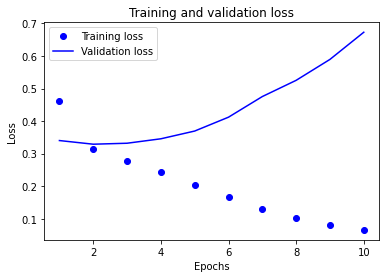

In [224]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점 추정


- validation loss의 그래프가 train loss와의 이격이 너무 빠르게 발생 -> 문제

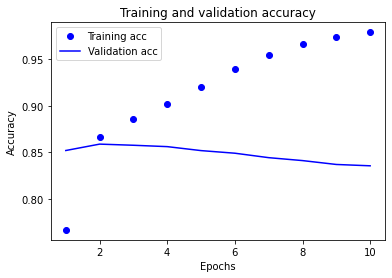

In [225]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- LSTM과 마찬가지로 이격이 크게 발생

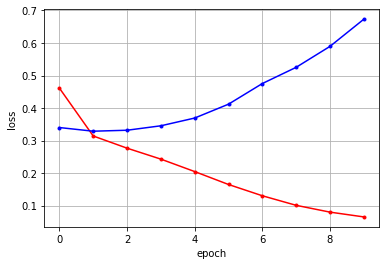

In [226]:
y_loss = history.history['loss']
y_val_loss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

---

## 1.3 RNN + 1-d Cnn


In [330]:

vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

model.add(keras.layers.Conv1D(32, 7, activation='relu'))

model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv1D(64, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(4))

#model.add(keras.layers.Conv1D(128, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D()) 

model.add(keras.layers.Dropout(0.2))


model.add(keras.layers.GRU(32))


model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, None, 20)          200000    
_________________________________________________________________
conv1d_71 (Conv1D)           (None, None, 32)          4512      
_________________________________________________________________
dropout_27 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, None, 64)          14400     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, None, 64)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
gru_22 (GRU)                 (None, 32)              

In [331]:
# validation set 분리
separation_train = int(x_train.shape[0]*0.2)
x_val = x_train[:separation_train]   
y_val = y_train[:separation_train]

# validation set을 제외한 나머지
partial_x_train = x_train[separation_train:]  
partial_y_train = y_train[separation_train:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(116946, 51)
(116946,)
(29236, 51)
(29236,)


- 1.3 RNN + 1-d Cnn

In [332]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # 0, 1 이진 문제므로 binary_crossentropy 사용
              metrics=['accuracy'])
              
epochs=9  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# batch_size -> 256

Epoch 1/9
229/229 [==============================] - 2s 8ms/step - loss: 0.5970 - accuracy: 0.6939 - val_loss: 0.5349 - val_accuracy: 0.7782
Epoch 2/9
229/229 [==============================] - 1s 7ms/step - loss: 0.5028 - accuracy: 0.7953 - val_loss: 0.4992 - val_accuracy: 0.7870
Epoch 3/9
229/229 [==============================] - 1s 7ms/step - loss: 0.4598 - accuracy: 0.8141 - val_loss: 0.4832 - val_accuracy: 0.7901
Epoch 4/9
229/229 [==============================] - 1s 7ms/step - loss: 0.4238 - accuracy: 0.8302 - val_loss: 0.4768 - val_accuracy: 0.7893
Epoch 5/9
229/229 [==============================] - 2s 7ms/step - loss: 0.3933 - accuracy: 0.8435 - val_loss: 0.4730 - val_accuracy: 0.7893
Epoch 6/9
229/229 [==============================] - 2s 7ms/step - loss: 0.3674 - accuracy: 0.8540 - val_loss: 0.4765 - val_accuracy: 0.7869
Epoch 7/9
229/229 [==============================] - 1s 7ms/step - loss: 0.3451 - accuracy: 0.8624 - val_loss: 0.4859 - val_accuracy: 0.7874
Epoch 8/9
229

In [333]:
# 모델 평가
model_results = model.evaluate(x_test,  y_test, verbose=2)
print(model_results)

1537/1537 - 5s - loss: 0.5185 - accuracy: 0.7860
[0.518547534942627, 0.7859511375427246]


In [334]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- 그래프로 그려 시각화

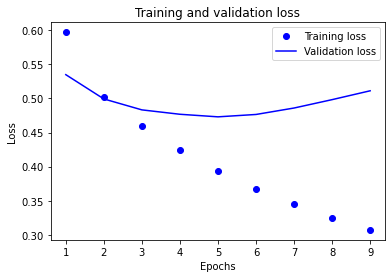

In [335]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점 추정


- validation loss의 그래프가 train loss와의 이격이 너무 빠르게 발생 -> 문제

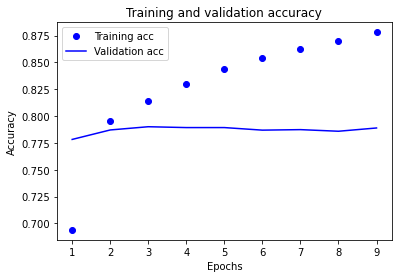

In [336]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- LSTM, 1D-CNN과 같은 문제 발생

- 1d-cnn + RNN을 합친다해서 더 좋은 모델이 되는건 아닌것같다.

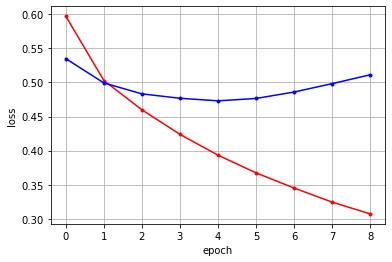

In [337]:
y_loss = history.history['loss']
y_val_loss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Word2Vec의 적용 [워드 임베딩] 
---
#### 워드 임베딩(word embedding) 기법 

- 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법

워드 임베딩으로 모델 학습 성능 개선

In [339]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
# 10000개의 단어 사전

(10000, 20)


In [340]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_ko.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

 한국어 Word2Vec 임베딩 활용하여 성능개선

- gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다.

In [341]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['나무']
vector

array([-0.08593687, -0.04961475, -0.14682527, -0.03745231,  0.00542662,
       -0.03151956,  0.01963768, -0.00105669, -0.04979969, -0.08913935,
       -0.1730272 , -0.08016104,  0.05221648,  0.00836838,  0.02334639,
       -0.05327123,  0.05258184,  0.00158501, -0.04481374,  0.06737486],
      dtype=float32)

- 학습된 워드 벡터에서 단어를 주어 해당 단어와 유사한 단어 나타내기

In [346]:
word_vectors.similar_by_word("하늘")

[('늙', 0.8662511110305786),
 ('동의', 0.8125020265579224),
 ('스러', 0.8049744367599487),
 ('출신', 0.7889511585235596),
 ('긴', 0.7855370044708252),
 ('갱', 0.7838460206985474),
 ('낡', 0.7802380919456482),
 ('헐리', 0.779589831829071),
 ('발버둥', 0.7788864374160767),
 ('때메', 0.7788003087043762)]

- 학습된 워드 벡터가 좋은 결과를 나타내지 않는다.

---

###  한국어 Word2Vec 임베딩 활용
### 1D-CNN + RNN 
- 최적의 하이퍼 파라미터 : Dropout 0.4, 0.,3  GRU(40)  

losss : 0.3431110382080078   
accuracy : 0.8551172614097595

- 2번째로 높은 하이퍼 파라미터 : Dropout 0.3, 0.,2  GRU(32)
   - Dropout의 값을 높여 준게 성능향상의 영향을 준것 같다.

loss : 0.3554093539714813   
accuracy : 0.8525133728981018  

-  Word2Vec 활용한 후 월등한 성능 향상을 보여주었다.

---

In [2]:
from gensim import models
import gensim
import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
word2vec_ko = gensim.models.Word2Vec.load(word2vec_path)

In [17]:
vector = word2vec_ko['바위']
vector     # 200dim의 워드 벡터입니다.

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 1.1514541e+00, -6.9829971e-01,  5.1037413e-01, -7.2899258e-01,
       -9.4888687e-01,  1.7572470e-01,  8.9921057e-01, -1.3143352e-01,
        2.1661602e-01,  1.4544671e+00,  1.5468161e+00,  9.0732053e-02,
       -1.3391463e+00,  9.5769143e-01,  1.5690635e+00,  2.0181141e+00,
       -4.2060715e-01,  8.1535000e-01,  4.0587443e-01, -1.7204196e+00,
       -1.8905382e+00, -8.3004087e-01,  7.1928662e-01,  1.7933643e+00,
       -1.1815268e+00, -2.2641279e-01,  2.9251590e+00,  3.8957193e-01,
        6.2811023e-01, -9.7262663e-01,  6.3567483e-01, -8.2137674e-01,
       -4.8207602e-01, -5.2974856e-01,  1.2983459e+00, -8.8676381e-01,
        8.2100493e-01,  2.3882358e+00,  3.1545445e-02,  1.1185359e+00,
       -3.5426736e-01,  8.0915773e-01, -4.7398126e-01, -2.7063377e+00,
       -5.2099943e-01, -2.5914320e-01,  9.6753508e-02,  1.5363537e+00,
       -4.5348138e-01,  7.4460477e-01,  2.0737967e+00,  2.0052508e-01,
        1.8644301e+00,  3.4138578e-01, -9.5809656e-01,  1.0188689e+00,
      

- 유사성 확인하기

In [18]:
word2vec_ko.similar_by_word("넥타이")

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('셔츠', 0.8049362897872925),
 ('반바지', 0.7742342948913574),
 ('바지', 0.699009358882904),
 ('망토', 0.6981318593025208),
 ('허리띠', 0.6888015270233154),
 ('기모노', 0.6824862360954285),
 ('외투', 0.6823244094848633),
 ('저고리', 0.6793856620788574),
 ('선글라스', 0.6763491630554199),
 ('머리', 0.6734156012535095)]

In [19]:
vocab_size = 10000    # 어휘 사전의 크기입니다(20,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec_ko:
        embedding_matrix[i] = word2vec_ko[index_to_word[i]]

/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/ssac27/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


- Word2Vec의 워드 벡터로 모델 재학습

In [25]:

vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.Conv1D(32, 7, activation='relu'))

model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv1D(64, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))

#model.add(keras.layers.Conv1D(128, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D()) 

model.add(keras.layers.Dropout(0.2))


model.add(keras.layers.GRU(32))


model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 51, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 45, 32)            44832     
_________________________________________________________________
dropout (Dropout)            (None, 45, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 39, 64)            14400     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
gru (GRU)                    (None, 32)               

In [113]:

vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.Conv1D(32, 7, activation='relu'))

model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Conv1D(64, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))

#model.add(keras.layers.Conv1D(128, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D()) 

model.add(keras.layers.Dropout(0.3))


model.add(keras.layers.GRU(40))


model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 51, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 45, 32)            44832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 39, 64)            14400     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
gru_24 (GRU)                 (None, 40)              

In [114]:
# 학습의 진행
#Dropout 0.4, 0.,3  GRU(40)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 20s 89ms/step - loss: 0.6758 - accuracy: 0.5508 - val_loss: 0.5386 - val_accuracy: 0.7377
Epoch 2/10
229/229 [==============================] - 20s 86ms/step - loss: 0.4527 - accuracy: 0.7904 - val_loss: 0.3799 - val_accuracy: 0.8312
Epoch 3/10
229/229 [==============================] - 19s 85ms/step - loss: 0.3739 - accuracy: 0.8349 - val_loss: 0.3459 - val_accuracy: 0.8500
Epoch 4/10
229/229 [==============================] - 19s 85ms/step - loss: 0.3369 - accuracy: 0.8542 - val_loss: 0.3353 - val_accuracy: 0.8538
Epoch 5/10
229/229 [==============================] - 19s 85ms/step - loss: 0.3169 - accuracy: 0.8651 - val_loss: 0.3322 - val_accuracy: 0.8546
Epoch 6/10
229/229 [==============================] - 19s 85ms/step - loss: 0.3019 - accuracy: 0.8733 - val_loss: 0.3296 - val_accuracy: 0.8591
Epoch 7/10
229/229 [==============================] - 19s 85ms/step - loss: 0.2886 - accuracy: 0.8800 - val_loss: 0.3304 - val_accuracy:

In [26]:
# 학습의 진행
# Dropout 0.3 , 0.2 GRU(32) 
# -> GRU(40)이 더 나은 결과 발생
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 19s 84ms/step - loss: 0.6480 - accuracy: 0.6238 - val_loss: 0.5546 - val_accuracy: 0.7767
Epoch 2/10
229/229 [==============================] - 19s 83ms/step - loss: 0.5150 - accuracy: 0.8001 - val_loss: 0.4715 - val_accuracy: 0.8251
Epoch 3/10
229/229 [==============================] - 19s 85ms/step - loss: 0.4007 - accuracy: 0.8329 - val_loss: 0.3588 - val_accuracy: 0.8409
Epoch 4/10
229/229 [==============================] - 20s 85ms/step - loss: 0.3367 - accuracy: 0.8560 - val_loss: 0.3368 - val_accuracy: 0.8520
Epoch 5/10
229/229 [==============================] - 20s 87ms/step - loss: 0.3117 - accuracy: 0.8697 - val_loss: 0.3360 - val_accuracy: 0.8548
Epoch 6/10
229/229 [==============================] - 19s 84ms/step - loss: 0.2937 - accuracy: 0.8774 - val_loss: 0.3358 - val_accuracy: 0.8570
Epoch 7/10
229/229 [==============================] - 19s 83ms/step - loss: 0.2802 - accuracy: 0.8846 - val_loss: 0.3390 - val_accuracy:

#### 
Dropout 0.4, 0.,3  GRU(40)

In [27]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3554 - accuracy: 0.8525
[0.3554093539714813, 0.8525133728981018]


In [115]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3431 - accuracy: 0.8551
[0.3431110382080078, 0.8551172614097595]


In [29]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


---

### 그래프로 시각화
- Word2Vec를 하고 난 후의 성능이 어떻게 바뀌었는지 확인

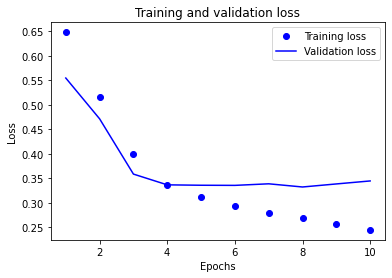

In [31]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

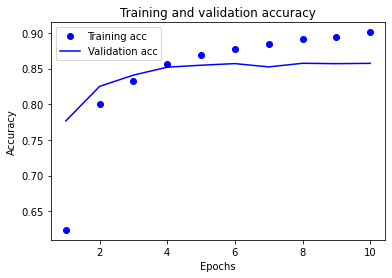

In [32]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

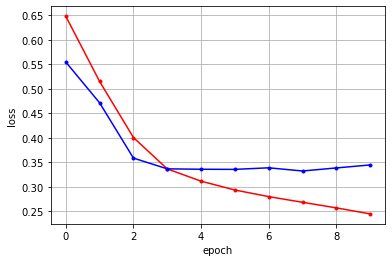

In [33]:
y_loss = history.history['loss']
y_val_loss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

- 위에서 진행했었던 워드 임베딩 사용전의 GRU + 1D-CNN보다 확연히 완만한 그래프 양상을 띄운다.

- Word2Vec를 활용한 후 성능이 향상함을 확인할 수 있다.

---
#### 아래가 1D-CNN + RNN를 활용한 모델의 그래프이다.

- 위의 그래프와 비교 해봤을때 Word2Vec를 활용한 모델이 더 나은 결과를 나타냈다.

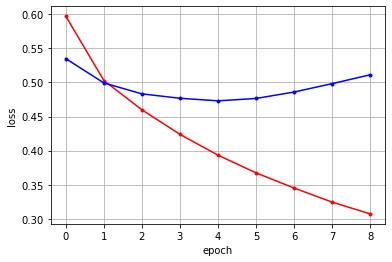

In [337]:
y_loss = history.history['loss']
y_val_loss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

---

## 한국어 Word2Vec 사용 ( GRU )

- 가장 좋은 결과를 보여준 하이퍼 파라미터 : GRU(40)  

loss : 0.39577534794807434  
accuracy : 0.851211428642273

- 2번째로 좋은 결과를 보여준 하이퍼 파라미터 : GRU(26)
   - 정확도는 85를 넘지 못했지만 2번째로 낮은 loss 값을 보여주었다.  
   
loss : 0.3983360230922699  
accuracy : 0.8460646271705627

In [105]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen))   # trainable을 True로 주면 Fine-tuning
# trainable [Fine-tuining] :
# 기존에 학습되어져 있는 모델을 기반으로 아키텍쳐를 새로운 목적(나의 이미지 데이터에 맞게)
# 변형하고 이미 학습된 모델 Weights로 부터 학습을 업데이트하는 방법

model.add(keras.layers.GRU(26))   # RNN 모델 중 GRU 레이어를 사용하였습니다. 

model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 51, 200)           2000000   
_________________________________________________________________
gru_23 (GRU)                 (None, 26)                17784     
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 216       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 2,018,009
Trainable params: 2,018,009
Non-trainable params: 0
_________________________________________________________________


In [106]:
# 학습의 진행 GRU(26)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=9  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/9
229/229 [==============================] - 17s 73ms/step - loss: 0.6665 - accuracy: 0.5690 - val_loss: 0.5635 - val_accuracy: 0.7087
Epoch 2/9
229/229 [==============================] - 16s 71ms/step - loss: 0.4452 - accuracy: 0.7924 - val_loss: 0.3872 - val_accuracy: 0.8279
Epoch 3/9
229/229 [==============================] - 16s 72ms/step - loss: 0.3380 - accuracy: 0.8548 - val_loss: 0.3445 - val_accuracy: 0.8506
Epoch 4/9
229/229 [==============================] - 16s 72ms/step - loss: 0.2966 - accuracy: 0.8763 - val_loss: 0.3349 - val_accuracy: 0.8571
Epoch 5/9
229/229 [==============================] - 16s 71ms/step - loss: 0.2709 - accuracy: 0.8890 - val_loss: 0.3391 - val_accuracy: 0.8573
Epoch 6/9
229/229 [==============================] - 16s 72ms/step - loss: 0.2493 - accuracy: 0.8997 - val_loss: 0.3419 - val_accuracy: 0.8597
Epoch 7/9
229/229 [==============================] - 16s 72ms/step - loss: 0.2291 - accuracy: 0.9094 - val_loss: 0.3468 - val_accuracy: 0.8567

In [80]:
# 학습의 진행 GRU(40)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
229/229 [==============================] - 19s 82ms/step - loss: 0.6881 - accuracy: 0.5191 - val_loss: 0.6136 - val_accuracy: 0.6816
Epoch 2/10
229/229 [==============================] - 19s 81ms/step - loss: 0.4529 - accuracy: 0.7871 - val_loss: 0.3842 - val_accuracy: 0.8279
Epoch 3/10
229/229 [==============================] - 19s 83ms/step - loss: 0.3329 - accuracy: 0.8569 - val_loss: 0.3331 - val_accuracy: 0.8555
Epoch 4/10
229/229 [==============================] - 19s 82ms/step - loss: 0.2888 - accuracy: 0.8801 - val_loss: 0.3298 - val_accuracy: 0.8585
Epoch 5/10
229/229 [==============================] - 19s 83ms/step - loss: 0.2644 - accuracy: 0.8920 - val_loss: 0.3289 - val_accuracy: 0.8603
Epoch 6/10
229/229 [==============================] - 19s 82ms/step - loss: 0.2415 - accuracy: 0.9031 - val_loss: 0.3377 - val_accuracy: 0.8618
Epoch 7/10
229/229 [==============================] - 19s 82ms/step - loss: 0.2205 - accuracy: 0.9136 - val_loss: 0.3465 - val_accuracy:

In [108]:
# 테스트셋을 통한 모델 평가 GRU(26)
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3983 - accuracy: 0.8461
[0.3983360230922699, 0.8460646271705627]


In [81]:
# 테스트셋을 통한 모델 평가 GRU(40)
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3958 - accuracy: 0.8512
[0.39577534794807434, 0.851211428642273]


In [109]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 그래프로 시각화
- Word2Vec를 하고 난 후의 성능이 어떻게 바뀌었는지 확인

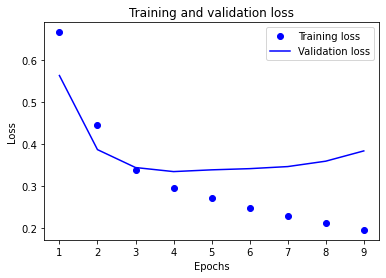

In [110]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

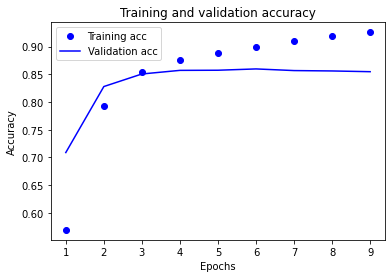

In [111]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

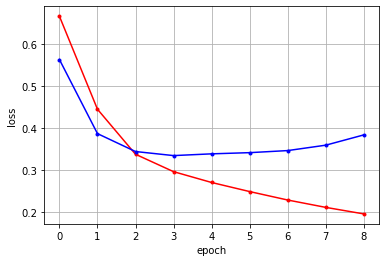

In [112]:
y_loss = history.history['loss']
y_val_loss = history.history['val_loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker='.', c='red', label='Traing set')
plt.plot(x_len, y_val_loss, marker='.', c='blue', label='testing set')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

- 전반적으로 Word2Vec를 활용하면 그래프가 좀더 완만한 형상을 띄운것을 알 수 있다.

### 네이버 영화 리뷰 감성 분석을 마치며

- 기존의 딥러닝은 이미지 분류로만 사용했는데 처음으로 자연어 처리(NLP)를 진행하면서 지금까지 했던 프로젝트 중에서 새로운 것을 배워가고 활용했다는 느낌이 가장 많이 들었던 것 같다.  


- 개인적으로는 이론적인 부분은 이미지 분류가 자연어 처리보다 좀 더 이해가 되었고 활용 적인 부분에서는 자연어 처리가 이미지 분류보다 더 어렵지 않게 다룰 수 있던거 같다.


- 그리고 이번 프로젝트에서 크게 기억 남는 것은 워드 임베딩이 자연어 처리에서 왜 중요한지 알게 되었습니다.<br> 물론, GRU같은 경우 loss가 0.37에서 0.39로 증가 하고 accuracy도 큰 변화가 없었지만,  ( 1D-CNN + RNN )에 워드 임베딩을 적용하면서 loss가 0.51 -> 0.34,  accuracy가 0.78 -> 0.85로 성능이 크게 향상된 것을 직접 확인할 수 있어서 **워드 임베딩**에 중요성을 더 알게된것 같습니다.


- 이렇게 프로젝트를 무사히 마치면서 하루만 쉬고 싶지만 아직 진행중인 프로젝트랑 해야할 숙제들이 남아 있어서 이번 주도 제대로 못 쉬고 넘길것 같네요. 머신러닝이나 딥러닝이나 막상 해보면 뭔가 할만한것 같은 느낌이 들지만... CS231n 등의 강의를 보면 이론적인 부분은 정말 어렵기도 하고 아직 가야할 산이 많다는 느낌이 든다.


- 그래도 강의를 듣고 모델을 사용하고 하면서 처음에 접했을때 보다는 더 발전했다고 생각한다. 